In [1]:
import numpy as np
import matplotlib.pyplot as plt

#cubed sphere
from itertools import product
import cartopy.crs as ccrs

# Question 1

### general rules
* All points in each region are closer to the region’s generating point than to any other generating point <br>
* Edges between two cells bisects (and is orthogonal to) the line joining the two generators (not relevant in 1D) <br>
* CVT = generating points are collocated with centers-ofmass of Voronoi regions

In [2]:
xmin = -1
xmax = 1
N = 3
dist = xmax - xmin #total area points can be between
divloc  = dist/(N)   #the distance between the edge and dividing line between regions = the total distance divided by the number of regions

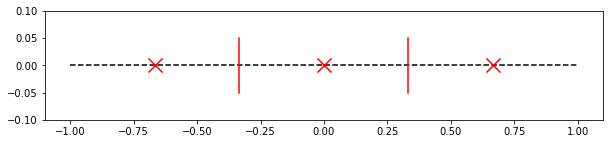

In [3]:
fig, ax = plt.subplots(1,1, figsize=(10,2))
ax.set_ylim([-0.1,0.1])
ax.set_xlim([-1.1,1.1])
ax.plot([-1,1],[0,0],'k--', zorder=0)
ax.plot([xmin+divloc,xmin+divloc],[-0.05,0.05],'r-', zorder=1) # barrier between left and centre cell
ax.plot([xmax-divloc,xmax-divloc],[-0.05,0.05],'r-', zorder=1) # barrier between right and center cell
ax.scatter([xmin+(divloc/2), xmin+(divloc*1.5), xmax-(divloc/2)], [0,0,0], c='r', zorder=1, marker='x', s=200) # the centre of masses of these cells

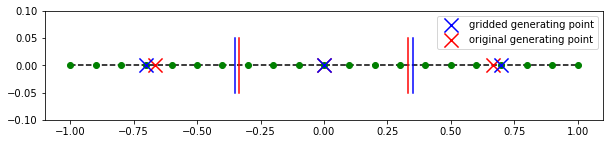

In [4]:
# now if the voronoi regions could only be defined at the grid points of dx=0.1
points = np.arange(-1,1.01,0.1)

fig, ax = plt.subplots(1,1, figsize=(10,2))
ax.set_ylim([-0.1,0.1])
ax.set_xlim([-1.1,1.1])
ax.plot([-1,1],[0,0],'k--', zorder=0)
ax.plot([np.mean([points[3], points[10]]),np.mean([points[3], points[10]])],[-0.05,0.05],'b-', zorder=1) # barrier between left and centre cell
ax.plot([np.mean([points[10], points[17]]),np.mean([points[17], points[10]])],[-0.05,0.05],'b-', zorder=1) # barrier between right and center cell
ax.scatter([points[3], points[10], points[17]], [0,0,0], c='b', zorder=2, marker='x', s=200, label='gridded generating point') # the centre of masses of these cells

ax.plot([xmin+divloc,xmin+divloc],[-0.05,0.05],'r-', zorder=1) # barrier between left and centre cell
ax.plot([xmax-divloc,xmax-divloc],[-0.05,0.05],'r-', zorder=1) # barrier between right and center cell
ax.scatter([xmin+(divloc/2), xmin+(divloc*1.5), xmax-(divloc/2)], [0,0,0], c='r', zorder=1, marker='x', s=200, label='original generating point') # the centre of masses of these cells

ax.scatter(points, np.zeros(len(points)), c='g')

ax.legend()

If points must be defined along the grid (green points) then the location of the generating points does change. While the regions are no longer the same size (the centre region is larger) it is still a CVT, with points in each cell closer to the generating point of their cell than to any other generating point as long as these points are drawn along the grid. 

The answer drawn by inspection divides the region by region length, while the answer darwn along the grid divides the region by number of cells. 

# Question 4

code adapted from: https://gist.github.com/darothen/8bf53b448790f21f616552b45ee3b22b

#### Functions

In [5]:
def latlon_to_cartesian(lon, lat):
    """ Convert latitude/longitude coordinates along the unit sphere to cartesian coordinates
    defined by a vector pointing from the sphere's center to its surface. 
    
    Parameters
    ----------
    lon, lat : float
        Longitude and latitude coordinates in radians
        
    Returns
    -------
    Cartesian coordinate components x, y, z
    
    """
    
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    
    return x, y, z

def cartesian_to_latlon(x, y, z, ret_xyz=False):
    """ Convert a cartesian coordinate to latitude/longitude coordinates."""
       
    xyz = np.array([x, y, z])
    vector_length = np.sqrt(np.sum(xyz*xyz, axis=0))
    xyz /= vector_length
    x, y, z = xyz
    
    if (np.abs(x) + np.abs(y)) < 1e-20:
        lon = 0.
    else:
        lon = np.arctan2(y, x) 
    if lon < 0.:
        lon += 2*np.pi
        
    lat = np.arcsin(z)
    # If not normalizing vector, take lat = np.arcsin(z/vector_length)
    
    if ret_xyz:
        return lon, lat, xyz
    else:
        return lon, lat

def spherical_to_cartesian(theta, phi, r=1):
    x = r * np.cos(phi) * np.cos(theta)
    y = r * np.cos(phi) * np.sin(theta)
    z = r * np.sin(phi)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(y, x)
    phi = np.arctan2(z, np.sqrt(x**2 + y**2))
        
    return theta, phi, r

def rotate_sphere_3D(theta, phi, r, rot_ang, rot_axis='x'):    
    cos_ang = np.cos(rot_ang)
    sin_ang = np.sin(rot_ang)
    
    x, y, z = spherical_to_cartesian(theta, phi, r)
    if rot_axis == 'x':
        x_new = x
        y_new = cos_ang*y + sin_ang*z
        z_new = -sin_ang*y + cos_ang*z
    elif rot_axis == 'y':
        x_new = cos_ang*x - sin_ang*z
        y_new = y
        z_new = sin_ang*x + cos_ang*z
    elif rot_axis == 'z':
        x_new = cos_ang*x + sin_ang*y
        y_new = -sin_ang*x + cos_ang*y
        z_new = z
    
    theta_new, phi_new, r_new = cartesian_to_spherical(x_new, y_new, z_new)
    
    return theta_new, phi_new, r_new

def shift_lons(lons):
    new_lons = np.empty_like(lons)
    mask = lons > 180
    new_lons[mask] = -(360. - lons[mask])
    new_lons[~mask] = lons[~mask]
    lons = new_lons.copy()
    return lons

# vectorize a whole bunch of em
vec_latlon_to_cartesian = np.vectorize(latlon_to_cartesian)
vec_cartesian_to_latlon = np.vectorize(cartesian_to_latlon)
vec_spherical_to_cartesian = np.vectorize(spherical_to_cartesian)
vec_cartesian_to_spherical = np.vectorize(cartesian_to_spherical)

In [6]:
# the face computation and mirroring:

def cube_mesh(lambda_rad, theta_rad, c):
    
    # compute teh latitude and longitude at the face corners
    lonMir1, lonMir2 = lambda_rad[0, 0], lambda_rad[-1, -1]
    latMir1, latMir2 = theta_rad[0, 0], theta_rad[-1, -1]

    xyzMir1 = latlon_to_cartesian(lonMir1, latMir1)
    xyzMir2 = latlon_to_cartesian(lonMir2, latMir2)

    xyzCross = np.cross(xyzMir1, xyzMir2)
    norm = np.sqrt(np.sum(xyzCross**2))
    xyzCross /= norm

    for i in range(1, c):

        lonRef, latRef = lambda_rad[0, i], theta_rad[0, i]
        xyzRef = np.asarray(latlon_to_cartesian(lonRef, latRef, ))

        xyzDot = np.sum(xyzCross*xyzRef)
        xyzImg = xyzRef - (2. * xyzDot * xyzCross)

        xsImg, ysImg, zsImg = xyzImg
        lonImg, latImg = cartesian_to_latlon(xsImg, ysImg, zsImg)

        lambda_rad[i, 0] = lonImg
        lambda_rad[i, -1] = lonImg
        theta_rad[i, 0] = latImg
        theta_rad[i, -1] = -latImg
        
    #infill the rest of the cube-sphere mesh
    pp = np.zeros([3, c+1, c+1])

    # Set the four corners
    for i, j in product([0, -1], [0, -1]):
        # print(i, j)
        pp[:, i, j] = latlon_to_cartesian(lambda_rad[i, j], theta_rad[i, j])

    # Map the edges on the sphere back to the cube. Note that all intersections are at x = -rsq3
    for ij in range(1, c+1):
        # print(ij)
        pp[:, 0, ij] = latlon_to_cartesian(lambda_rad[0, ij], theta_rad[0, ij])
        pp[1, 0, ij] = -pp[1, 0, ij] * inv_sqrt_3 / pp[0, 0, ij]
        pp[2, 0, ij] = -pp[2, 0, ij] * inv_sqrt_3 / pp[0, 0, ij]

        pp[:, ij, 0] = latlon_to_cartesian(lambda_rad[ij, 0], theta_rad[ij, 0])
        pp[1, ij, 0] = -pp[1, ij, 0] * inv_sqrt_3 / pp[0, ij, 0]
        pp[2, ij, 0] = -pp[2, ij, 0] * inv_sqrt_3 / pp[0, ij, 0]  

    # # Map interiors
    pp[0, :, :] = -inv_sqrt_3
    for i in range(1, c+1):
        for j in range(1, c+1):
            # Copy y-z face of the cube along j=1
            pp[1, i, j] = pp[1, i, 0]
            # Copy along i=1
            pp[2, i, j] = pp[2, 0, j]

    llr, ttr = vec_cartesian_to_latlon(pp[0], pp[1], pp[2])   
    
    new_xgrid = np.zeros((c+1, c+1, 6))
    new_ygrid = np.zeros((c+1, c+1, 6))

    xgrid = llr.copy()
    ygrid = ttr.copy()

    new_xgrid[..., 0] = xgrid.copy()
    new_ygrid[..., 0] = ygrid.copy()

    radius = 1.

    for face in range(1, 6):
        if face > 5: continue
        for j in range(c+1):
            for i in range(c+1):
                x = xgrid[i, j]
                y = ygrid[i, j]
                z = radius

                if face == 1:
                    # Rotate about z only
                    new_xyz = rotate_sphere_3D(x, y, z, -np.pi/2., 'z')

                elif face == 2:
                    # Rotate about z, then x
                    temp_xyz = rotate_sphere_3D(x, y, z, -np.pi/2., 'z')                
                    x, y, z = temp_xyz[:]
                    new_xyz = rotate_sphere_3D(x, y, z, np.pi/2., 'x')

                elif face == 3:
                    temp_xyz = rotate_sphere_3D(x, y, z, np.pi, 'z')
                    x, y, z = temp_xyz[:]
                    new_xyz = rotate_sphere_3D(x, y, z, np.pi/2., 'x')

                    if ((c % 2) != 0) and (j == c//2 - 1):
                        print(i, j, face)
                        new_xyz[0] = np.pi

                elif face == 4:
                    temp_xyz = rotate_sphere_3D(x, y, z, np.pi/2., 'z')                
                    x, y, z = temp_xyz[:]
                    new_xyz = rotate_sphere_3D(x, y, z,  np.pi/2., 'y')

                elif face == 5:
                    temp_xyz = rotate_sphere_3D(x, y, z,  np.pi/2., 'y')                
                    x, y, z = temp_xyz[:]
                    new_xyz = rotate_sphere_3D(x, y, z, 0., 'z')

                # print((x, y, z), "\n", new_xyz, "\n" + "--"*40)

                new_x, new_y, _ = new_xyz
                new_xgrid[i, j, face] = new_x
                new_ygrid[i, j, face] = new_y  
                
    lon_edge, lat_edge = new_xgrid.copy(), new_ygrid.copy()
    
    
    offset = np.pi/18.
    lon_edge = lon_edge - offset

    for i, j, f in product(range(c+1), range(c+1), range(6)):
        new_lon = lon_edge[i, j, f]
        if new_lon < 0:
            new_lon+= 2*np.pi
        if np.abs(new_lon) < 1e-10:
            new_lon = 0.
        lon_edge[i, j, f] = new_lon

        if np.abs(lat_edge[i, j, f]) < 1e-10:
            lat_edge[i, j, f] = 0.

    lon_edge_deg = np.rad2deg(lon_edge)
    lat_edge_deg = np.rad2deg(lat_edge)
    
    return lon_edge_deg, lat_edge_deg

## First, Equidistant

In [7]:
c = 12 # number of cells per grid edge
inv_sqrt_3 = 1.0 / np.sqrt(3.0)
asin_inv_sqrt_3 = np.arcsin(inv_sqrt_3) # a 

# this is the part that differentatiates between the equidistant and equiangular projections
# equidistant:
delta_y = 2.*asin_inv_sqrt_3 / c # equally spaced between -a and a (hence the 2*a)

In [8]:
# compute face
nx, ny = c+1, c+1

lambda_rad = np.zeros((nx, ny))
lambda_rad[ 0, :] = 3.*np.pi/4. # West edge
lambda_rad[-1, :] = 5.*np.pi/4. # East edge

# this is the part that differentatiates between the equidistant and equiangular projections
# equidistant:
theta_rad = np.zeros((nx, ny))
theta_rad[ 0, :] = -asin_inv_sqrt_3 + (delta_y*np.arange(c+1)) # West edge
theta_rad[-1, :] = theta_rad[0, :] # East edge

In [9]:
lon_edge_deg, lat_edge_deg = cube_mesh(lambda_rad, theta_rad, c)

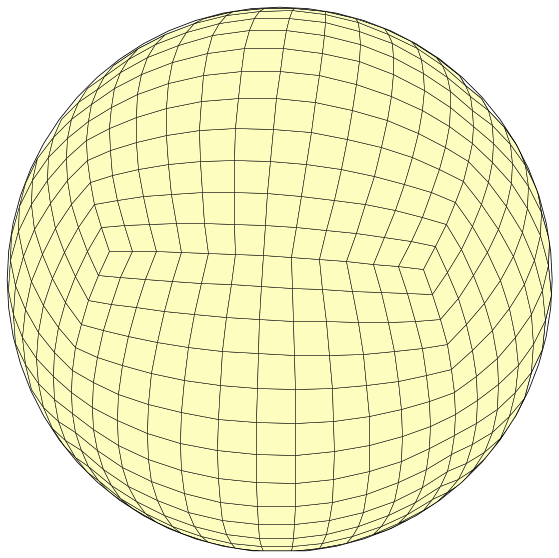

In [10]:
map_proj = ccrs.Orthographic(central_longitude=-95., central_latitude=40)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(
    111, 
    projection=map_proj
)

vmin, vmax = -0.01, 0.01
for face in range(6):
#     if face != 5: continue
    lons = shift_lons(lon_edge_deg[..., face])
    lats = lat_edge_deg[..., face]
    cc = np.zeros([c,c])
    if face == 5: cc = cc.T
    try:
        ax.pcolormesh(lons, lats, cc, edgecolor='k', lw=0.5, cmap='magma_r',
                      transform=ccrs.PlateCarree(),
                      antialiased=True,
        )
    except:
        pass

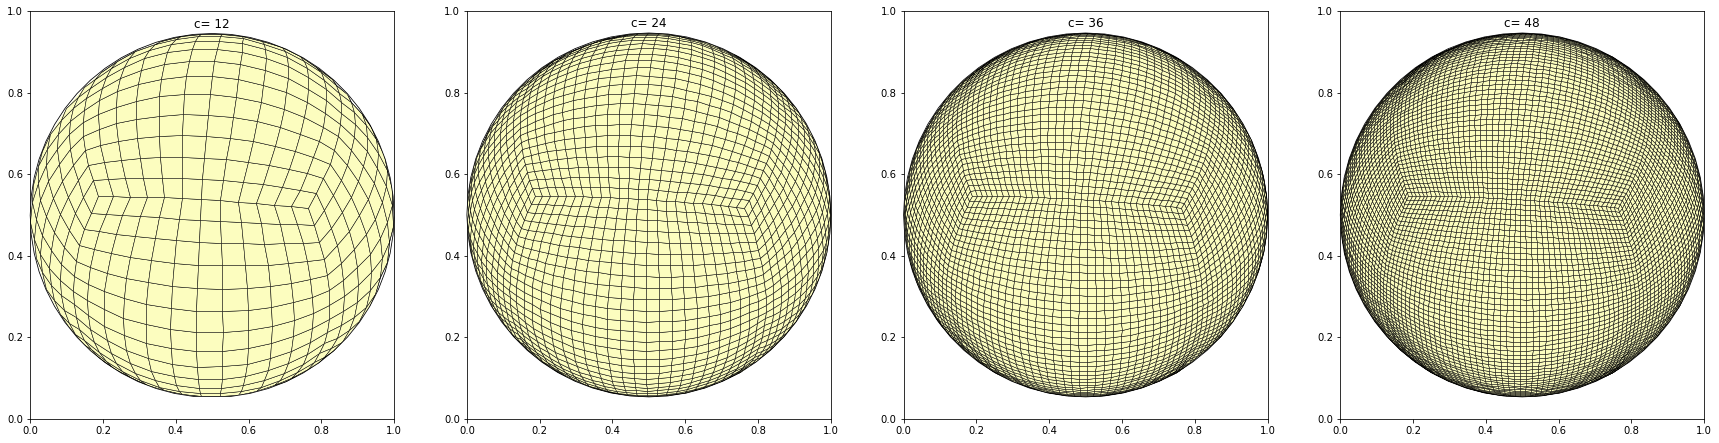

In [11]:
# do for c = 24, 36, 48

fig, ax = plt.subplots(1,4,figsize=(30,7.5))
cells = [12 ,24, 36, 48]
k=0
box = [141,142,143,144]

for i in range(len(cells)):
    c = cells[i] # number of cells per grid edge
    inv_sqrt_3 = 1.0 / np.sqrt(3.0)
    asin_inv_sqrt_3 = np.arcsin(inv_sqrt_3) # a 
    delta_y = 2.*asin_inv_sqrt_3 / c # equally spaced between -a and a (hence the 2*a)
    
    # compute face
    nx, ny = c+1, c+1

    lambda_rad = np.zeros((nx, ny))
    lambda_rad[ 0, :] = 3.*np.pi/4. # West edge
    lambda_rad[-1, :] = 5.*np.pi/4. # East edge

    # this is the part that differentatiates between the equidistant and equiangular projections
    # equidistant:
    theta_rad = np.zeros((nx, ny))
    theta_rad[ 0, :] = -asin_inv_sqrt_3 + (delta_y*np.arange(c+1)) # West edge
    theta_rad[-1, :] = theta_rad[0, :] # East edge
    
    lon_edge_deg, lat_edge_deg = cube_mesh(lambda_rad, theta_rad, c)
    
    ax[k] = fig.add_subplot(
        box[i], 
        projection=map_proj
    )
    
    title = 'c= '+str(c)
    ax[k].set_title(title)
    
    for face in range(6):
        lons = shift_lons(lon_edge_deg[..., face])
        lats = lat_edge_deg[..., face]
        cc = np.zeros([c,c])
        if face == 5: cc = cc.T
        try:
            ax[k].pcolormesh(lons, lats, cc, edgecolor='k', lw=0.5, cmap='magma_r',
                          transform=ccrs.PlateCarree(),
                          antialiased=True
            )
        except:
            pass  
    k+=1

## and equiangular

In [12]:
c = 12 # number of cells per grid edge
inv_sqrt_3 = 1.0 / np.sqrt(3.0)
asin_inv_sqrt_3 = np.arcsin(inv_sqrt_3) # a 

In [13]:
# compute face
nx, ny = c+1, c+1

lambda_rad = np.zeros((nx, ny))
lambda_rad[ 0, :] = 3.*np.pi/4. # West edge
lambda_rad[-1, :] = 5.*np.pi/4. # East edge

# this is the part that differentatiates between the equidistant and equiangular projections
# equidistant:
theta_rad = np.zeros((nx, ny))
theta_rad[ 0, :] = asin_inv_sqrt_3*np.tan(np.linspace(-np.pi/4,np.pi/4,c+1)) # West edge - x = a*tan(x0) for x0 between -pi/4 and pi/4
theta_rad[-1, :] = theta_rad[0, :] # East edge

In [14]:
lon_edge_deg, lat_edge_deg = cube_mesh(lambda_rad, theta_rad, c)

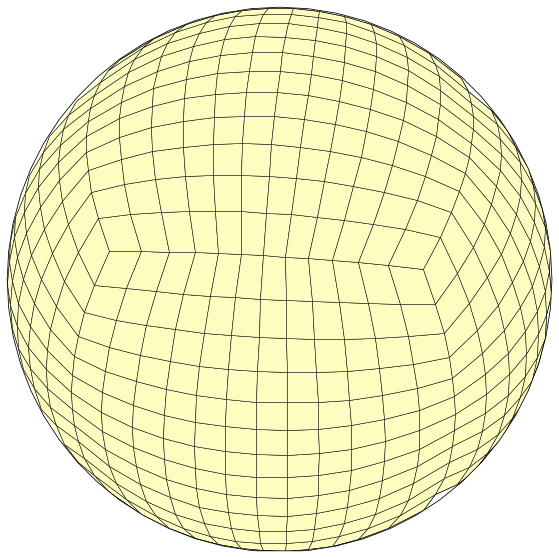

In [15]:
map_proj = ccrs.Orthographic(central_longitude=-95., central_latitude=40)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(
    111, 
    projection=map_proj
)

vmin, vmax = -0.01, 0.01
for face in range(6):
#     if face != 5: continue
    lons = shift_lons(lon_edge_deg[..., face])
    lats = lat_edge_deg[..., face]
    cc = np.zeros([c,c])
    if face == 5: cc = cc.T
    try:
        ax.pcolormesh(lons, lats, cc, edgecolor='k', lw=0.5, cmap='magma_r',
                      transform=ccrs.PlateCarree(),
                      antialiased=True,
        )
    except:
        pass

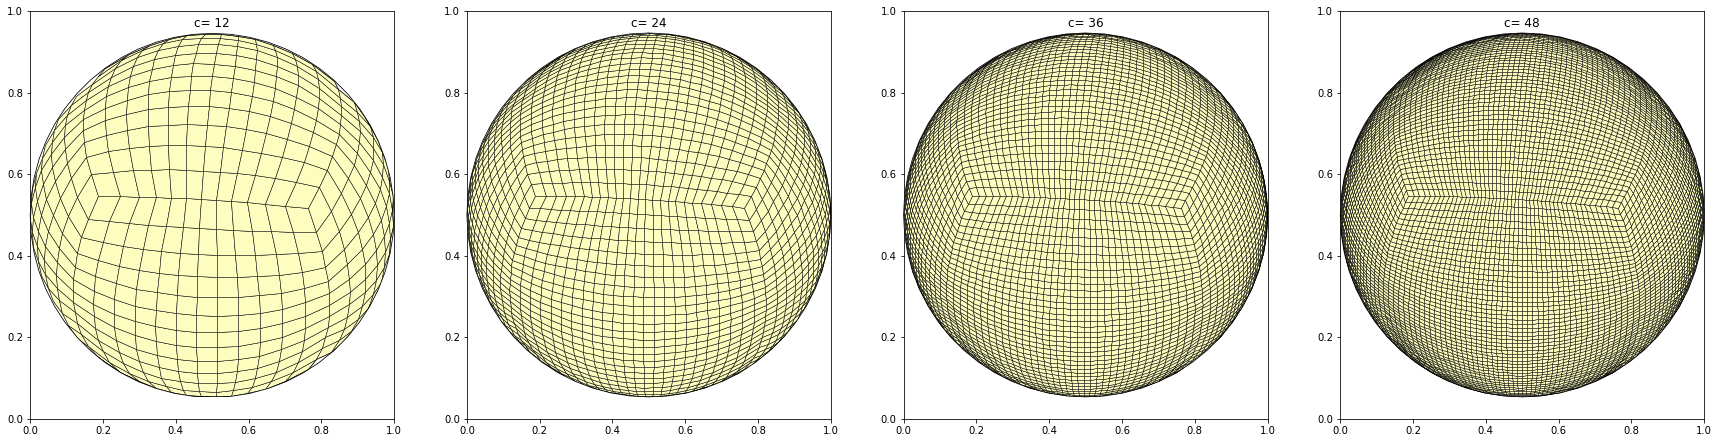

In [16]:
# do for c = 24, 36, 48

fig, ax = plt.subplots(1,4,figsize=(30,7.5))
cells = [12 ,24, 36, 48]
k=0
box = [141,142,143,144]

for i in range(len(cells)):
    c = cells[i] # number of cells per grid edge
    inv_sqrt_3 = 1.0 / np.sqrt(3.0)
    asin_inv_sqrt_3 = np.arcsin(inv_sqrt_3) # a 
    
    # compute face
    nx, ny = c+1, c+1

    lambda_rad = np.zeros((nx, ny))
    lambda_rad[ 0, :] = 3.*np.pi/4. # West edge
    lambda_rad[-1, :] = 5.*np.pi/4. # East edge

    # this is the part that differentatiates between the equidistant and equiangular projections
    # equidistant:
    theta_rad = np.zeros((nx, ny))
    theta_rad[ 0, :] = asin_inv_sqrt_3*np.tan(np.linspace(-np.pi/4,np.pi/4,c+1)) # West edge - x = a*tan(x0) for x0 between -pi/4 and pi/4
    theta_rad[-1, :] = theta_rad[0, :] # East edge
    
    lon_edge_deg, lat_edge_deg = cube_mesh(lambda_rad, theta_rad, c)
    
    ax[k] = fig.add_subplot(
        box[i], 
        projection=map_proj
    )
    
    title = 'c= '+str(c)
    ax[k].set_title(title)
    
    for face in range(6):
        lons = shift_lons(lon_edge_deg[..., face])
        lats = lat_edge_deg[..., face]
        cc = np.zeros([c,c])
        if face == 5: cc = cc.T
        try:
            ax[k].pcolormesh(lons, lats, cc, edgecolor='k', lw=0.5, cmap='magma_r',
                          transform=ccrs.PlateCarree(),
                          antialiased=True
            )
        except:
            pass  
    k+=1


### How do the two different projections compare?
The equiangular (the two sides of each cell are parallel) projection leads to a more equal distribuion of cells along the sphere - at locations further away from the face edges the equidistant (cells have a length to width ratio equal to 1) will be large compared to those close to the edge. However, the equangular cell shapes may be odd (more rectangular) compared to the equidistant cells (more square), so both ahve their strengths and weaknesses. 

### How do the different resolutions compare?

At higher resolutions the difference between the projection (and their respetive weaknesses) become more noticeable. In the equidistant projection the size difference between the face corners (tiny) and face centers (relatively large) becomes more and more apparent as the resolution increases. In the equiangular projection the deformation of the cell shape also increases, but less severely than the equidistant projection; cells at the center of the face edge are very thin comared to those at the corners.